In [175]:
import torch
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
from torchvision import transforms
import matplotlib.pyplot as plt


## Load Data

In [176]:
from pathlib import Path

data_dirs = [Path("./"), Path("../")]

tf = transforms.Compose([
    # 0.1307 is the mean of the MNIST dataset, 0.3081 is the standard deviation
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)), 
])

for data_dir in data_dirs:
    if (data_dir / "MNIST").exists():
        train_data = datasets.MNIST(data_dir, train=True, transform=tf)
        test_data = datasets.MNIST(data_dir, train=False, transform=tf)
        break
else:
    train_data = datasets.MNIST("./", train=True, download=True, transform=tf)
    test_data = datasets.MNIST("./", train=False, download=True, transform=tf)
    

g = torch.Generator().manual_seed(42)

train_data, val_data = random_split(train_data, [50000, 10000], generator=g)

## Model

### Patch


In [177]:
def patch(x: torch.Tensor, patch_size: int) -> torch.Tensor:
    """
    divide image into non-overlapping patches
    (B, C, H, W) -> (B, N, P*P*C) where N = (H/P)*(W/P)
    note: H and W must be divisible by P
    """
    if x.size(2) % patch_size != 0 or x.size(3) % patch_size != 0:
        raise ValueError("Height and Width must be divisible by patch_size")
    x = x.unfold(2,patch_size,patch_size).unfold(3,patch_size,patch_size)
    x = x.reshape(x.size(0), -1, patch_size * patch_size)
    return x

torch.Size([1, 1, 28, 28])
torch.Size([1, 49, 16])


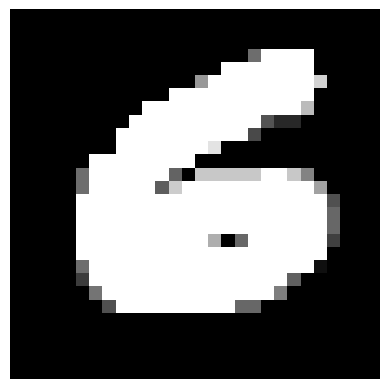

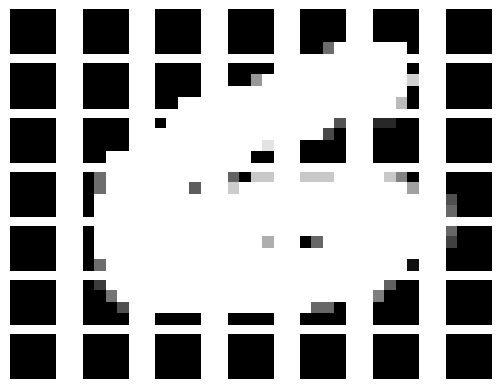

In [182]:
p = 4
inp  = train_data[0][0].unsqueeze(0)
print(inp.shape)
out = patch(inp, p)
print(out.shape)

plt.imshow(inp.squeeze(0,1), cmap='gray', vmin=0, vmax=1)
plt.axis('off')

fig = plt.figure()
for i in range(out.size(1)):
    fig.add_subplot(inp.size(2)// p,inp.size(2)//p,i+1)
    plt.imshow(out.squeeze(0)[i].reshape(p, p) , cmap='gray', vmin=0, vmax=1)
    plt.axis('off')


### Tokenization

In [183]:
class Tokenization(nn.Module):
    def __init__(self, patch_dim, emb_dim):
        """
        (B, N, P*P*C) -> (B, N, d)
        p_size = P*P*C
        """
        super().__init__()
        self.projection = nn.Linear(patch_dim, emb_dim)

    def forward(self, x:torch.Tensor):
        x = self.projection(x) # (B, N, 1, d) 
        return x.squeeze(-2)

### Attention

In [290]:
class SelfAttention(nn.Module):
    """
    (B, N+1, d) -> (B, N+1, d_k)
    d_q = d_k = d_v = d here
    note: d_q must equal to d_k in self-attention
    """
    def __init__(self, emb_dim):
        super().__init__()
        self.emb_dim = emb_dim
        self.Q = nn.Linear(emb_dim, emb_dim)
        self.K = nn.Linear(emb_dim, emb_dim)
        self.V = nn.Linear(emb_dim, emb_dim)
    
    def forward(self, x:torch.Tensor):
        R = self.Q(x) @ self.K(x).transpose(-1, -2)
        # (B, N+1, d) @ (B, d, N+1) -> (... N+1, N+1)
        #      Q             K               Q    K
        print(R.shape)
        print(self.V(x).shape)
        SA = (
            F.softmax(R / math.sqrt(self.emb_dim), -1) # soft max on K
            @ self.V(x))
        return SA

In [292]:
# ref: https://docs.pytorch.org/tutorials/beginner/nn_tutorial.html#using-nn-sequential
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

In [293]:
patch_size = 7
d_model = 20

model = nn.Sequential(
    Lambda(lambda x: patch(x, patch_size)),
    Tokenization(patch_size**2, d_model), # C == 1 in MNIST
    SelfAttention(d_model)
)

In [294]:
bs = 64

train_loader = DataLoader(train_data, batch_size=bs, shuffle=True)
val_loader = DataLoader(val_data, batch_size=bs*2, shuffle=True)

inp  = next(iter(train_loader))[0]
print(inp.shape)
out = model(inp)
print(out.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64, 16, 16])
torch.Size([64, 16, 20])
torch.Size([64, 16, 20])


In [68]:
import numpy as np
import math
from torch import Tensor

loss_func = F.cross_entropy

def accuracy(input:Tensor, target:Tensor):
    preds = torch.argmax(input, dim=1)
    return (preds == target).float().mean()

Train

Save & Test